In [1]:
## 0. load packages
import os, sys
import numpy as np
import pandas as pd
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import matplotlib.ticker as ticker
import matplotlib.colors as colors
import seaborn as sns
from scipy.stats import norm
from datetime import datetime

os.chdir('/h/u145/liuxinrui/CROP/')
sys.path.insert(0, '/h/u145/liuxinrui/CROP/')

impact_models =  ['CYGMA1p74', 'EPIC-IIASA', 'ISAM', 'LDNDC', 'LPJmL', 'PEPIC', 'PROMET', 'SIMPLACE-LINTUL5']
spcs = ['mai', 'ri1', 'ri2', 'soy', 'swh', 'wwh']

def load_crop_mask(ggcms =  ['CYGMA1p74', 'EPIC-IIASA', 'ISAM', 'LDNDC', 'LPJmL', 'PEPIC', 'PROMET', 'SIMPLACE-LINTUL5'],
    spcs = ['mai', 'ri1', 'ri2', 'soy', 'swh', 'wwh'],
    CHECK_TIMESERIES = True,
    APPLY_THRESHOLD = True,
    ROLLING = True,
    anomaly_window = 5,
    anomaly_ratio = 10,
    yd_threshold = 1.0e-6,
    rolling_window = 5,
    dir = '/h/u145/liuxinrui/Data/ISIMIP3b/RC/'
    ):
    '''
    Function to load GGCM-specific regional crop masks
    
    Options:
    ------
    model (list)                list of impact models
    spcs (list)                 list of crop species
    APPLY_THRESHOLD (bool)      whether to apply the threshold
    ROLLING (bool)              whether to apply the rolling window
    anomaly_window (int)        window size for the rolling window
    anomaly_ratio (int)         ratio for the rolling window
    yd_threshold (float)        threshold for the rolling window
    rolling_window (int)        window size for the rolling window
    dir (str)                   directory of the mask input data

    Output:
    -------
    mask (xarray.DataArray)     mask of the crop species
    '''
    print(f'Generate GGCM-specific regional crop masks for {ggcms} and {spcs}')
    txt_name = os.path.join(dir, 'RC', f'RC_{int(CHECK_TIMESERIES)}{int(APPLY_THRESHOLD)}{int(ROLLING)}_{anomaly_window:d}_{anomaly_ratio:d}yr_{yd_threshold:0.1e}_{str(rolling_window)}yr.csv')
    ftxt = pd.read_csv(txt_name, delimiter='\t')
    extrema_coords = list(ftxt[['model', 'irr', 'spc', 'reg']].itertuples(index=False, name=None))

    coord = xr.load_dataset('input_data/regions/region_coords.nc')
    coord.coords['mod_YD_crop'] = ggcms
    coord.coords['spc_crop'] = spcs
    coord.coords['irr'] = ['firr', 'noirr']
    mask = sum([xr.zeros_like(coord[dim], dtype=float) for dim in ['spc_crop', 'reg_land', 'irr', 'mod_YD_crop']])
    for mod, irr, spc, reg in extrema_coords:
        mask.loc[{'spc_crop': spc, 'reg_land': reg, 'irr': irr, 'mod_YD_crop': mod}] = True
    print(f'Number of coordinates to be masked: {mask.sum().item():0.0f}')
    return 1 - mask
    

In [2]:
## 1. load parameters

current_datetime = datetime.now()
print(f'\033[1;31;46mCurrent date and time: {current_datetime}\033[0m')

from core_fct.fct_loadP_CROP import load_ISIMIP3b_param
Par = load_ISIMIP3b_param()
Par['N_bnf'] = Par['N_bnf'].sel(mod_bnf_soy='Ma_2022', drop=True)
Par = Par.drop_dims(['mod_bnf_soy'])

## generate MC configurations
from core_fct.fct_genMC_old import generate_config
Par = generate_config(Par, nMC=3000)
print(Par)

Current date and time: 2025-05-15 15:09:36.881057
loading primary parameters
>>> Running split_region <<<
>>> Running split_region <<<
>>> Running split_region <<<
>>> Running split_region <<<
>>> Running split_region <<<
>>> Running split_region <<<
>>> Running split_region <<<
>>> Running split_region <<<
>>> Running split_region <<<
>>> Running split_region <<<
>>> Running split_region <<<
>>> Running split_region <<<
>>> Running split_region <<<
>>> Running split_region <<<
>>> Running split_region <<<
>>> Running split_region <<<
generating MC configurations
<xarray.Dataset>
Dimensions:        (reg_land: 292, config: 3000, spc_crop: 6, irr: 2)
Coordinates:
  * reg_land       (reg_land) int64 1 2 3 4 5 6 7 ... 287 288 289 290 291 292
    reg_land_code  (reg_land) object 'AFG' 'ALA' 'ALB' ... 'YEM' 'ZMB' 'ZWE'
    reg_land_name  (reg_land) object 'Afghanistan' 'Aland' ... 'Zimbabwe'
  * spc_crop       (spc_crop) object 'mai' 'ri1' 'ri2' 'soy' 'swh' 'wwh'
  * irr            (irr) obj

In [3]:
## 2. load drivers

from core_fct.fct_loadD_CROP import load_Nfertl_scen, load_Ndep_scen
soc = '2015soc'
For_Nfertl = load_Nfertl_scen(datasets=['ISIMIP3b-5crops']).sel(scen_N_fertl='ISIMIP3b-5crops-'+soc, drop=True).isel(year=0, drop=True)
print(For_Nfertl)

For_Ndep = load_Ndep_scen(datasets=['ISIMIP3b']).sel(scen_N_dep='ISIMIP3b-'+soc, drop=True)
print(For_Ndep)

For_clim_0 = xr.load_dataset('./input_data/observations/crop/land-climate_ISIMIP3b.nc').sel(scen='historical', drop=True).dropna('year', how='all')
For_clim_1 = xr.load_dataset('./input_data/observations/crop/land-climate_ISIMIP3b.nc').sel(scen='ssp585', drop=True).dropna('year', how='all')
For_co2_0 = xr.load_dataset('./input_data/observations/crop/concentrations_ISIMIP3b.nc').sel(scen='historical', drop=True).dropna('year', how='all')
For_co2_1 = xr.load_dataset('./input_data/observations/crop/concentrations_ISIMIP3b.nc').sel(scen='ssp585', drop=True).dropna('year', how='all')
For_clim = xr.concat([For_clim_0, For_clim_1], dim='year')
For_co2 = xr.concat([For_co2_0, For_co2_1], dim='year')

## set run options
ind0, ind1 = 1850, 2100
For = xr.merge([For_clim, For_co2, For_Nfertl, For_Ndep]).sel(year=slice(ind0, ind1))

## format drivers
## Initial CO2 here is 399.95 ppm
For['D_CO2'] = For.CO2 - Par['CO2_0']
For['D_Tl'] = For.Tl - For.Tl.sel(year=slice(1851, 1880)).mean('year')
For['D_Pl'] = For.Pl - For.Pl.sel(year=slice(1851, 1880)).mean('year')
For = For.drop_vars(['CO2', 'Tl', 'Pl'])
For = For.fillna(0).sel(year=slice(1850)).combine_first(For)

Loading 1 datasets for sub-national region
Loading nitrogen_fertl__ISIMIP3b-5crops_sub-national ...
<xarray.Dataset>
Dimensions:        (spc_crop: 6, reg_land: 292)
Coordinates:
  * reg_land       (reg_land) int64 1 2 3 4 5 6 7 ... 287 288 289 290 291 292
  * spc_crop       (spc_crop) <U3 'mai' 'ri1' 'ri2' 'soy' 'swh' 'wwh'
    reg_land_name  (reg_land) object 'Afghanistan' 'Aland' ... 'Zimbabwe'
    reg_land_code  (reg_land) object 'AFG' 'ALA' 'ALB' ... 'YEM' 'ZMB' 'ZWE'
Data variables:
    N_fertl        (spc_crop, reg_land) float64 0.1478 0.0 ... 0.3876 0.3665
Loading 1 datasets for sub-national region
Loading nitrogen_fertl__ISIMIP3b_sub-national ...
<xarray.Dataset>
Dimensions:        (year: 251, reg_land: 292)
Coordinates:
  * reg_land       (reg_land) int64 1 2 3 4 5 6 7 ... 287 288 289 290 291 292
    reg_land_name  (reg_land) object 'Afghanistan' 'Aland' ... 'Zimbabwe'
    reg_land_code  (reg_land) object 'AFG' 'ALA' 'ALB' ... 'YEM' 'ZMB' 'ZWE'
  * year           (year) int64 

In [4]:
## 3. import offline crop emulator and run emulations

from core_fct.mod_process_CROP import CROP
CROP = CROP()

print(CROP.proc_levels())
print(CROP.var_in)
print(CROP.var_mid)
print(CROP.var_out)
print(CROP._processes.keys())
print(CROP.var_prog)
print(CROP.var_node)
print(CROP.var_diag)

Out = CROP(None, Par, For, var_keep=['D_Tgs', 'D_Pgs', 'NI', 'RC', 'RT', 'RP', 'RN', 'YD'])
Out.to_netcdf('./results/results_ISIMIP3b.nc')

print(Out['RC'].max(), Out['RC'].min())
print(Out['RT'].max(), Out['RT'].min())
print(Out['RP'].max(), Out['RP'].min())
print(Out['RN'].max(), Out['RN'].min())
print(Out['YD'].max(), Out['YD'].min())

{0: [], 1: ['D_Tgs', 'NI', 'RC', 'D_Pgs'], 2: ['RT', 'RP', 'RN'], 3: ['YD']}
{'N_fertl', 'D_CO2', 'D_Pl', 'D_Tl', 'N_dep'}
{'D_Tgs', 'RN', 'NI', 'RC', 'D_Pgs', 'RT', 'RP'}
{'YD'}
dict_keys(['RC', 'D_Tgs', 'RT', 'D_Pgs', 'RP', 'NI', 'RN', 'YD'])
set()
set()
{'D_Tgs', 'RN', 'NI', 'RC', 'D_Pgs', 'RT', 'YD', 'RP'}
OSCAR_v3_CROP running


KeyboardInterrupt: 

In [4]:
## 4. load results

current_datetime = datetime.now()
print(f'\033[1;31;46mCurrent date and time: {current_datetime}\033[0m')

# Out = xr.load_dataset('./results/new/test.nc')
# print(Out)

# RC = xr.load_dataset('results/new/RC_noise.nc').weighted(load_cropland_weights()).mean('reg_land')
# RC = Out['RC'].weighted(load_cropland_weights()).mean('reg_land')
# RT = Out['RT'].weighted(load_cropland_weights()).mean('reg_land')
# RC.to_netcdf('./results/new/RC_global.nc')
# RT.to_netcdf('./results/RT_global.nc')

RC = xr.load_dataarray('./results/new/RC_global.nc')
RT = xr.load_dataarray('./results/new/RT_global.nc')
RP = xr.load_dataarray('./results/new/RP_global.nc')
YD = xr.load_dataarray('./results/new/YD_global.nc')
co2_0 = xr.load_dataarray('./input_data/observations/crop/concentrations_ISIMIP3b.nc').sel(scen='historical', drop=True).dropna('year', how='all')
co2_1 = xr.load_dataarray('./input_data/observations/crop/concentrations_ISIMIP3b.nc').sel(scen='ssp585', drop=True).dropna('year', how='all')
co2 = xr.concat([co2_0, co2_1], dim='year')
D_Tgs = xr.load_dataarray('./results/new/D_Tgs_global.nc')
D_Pgs = xr.load_dataarray('./results/new/D_Pgs_global.nc')

Current date and time: 2025-05-15 15:09:55.943128


Current date and time: 2025-04-22 22:54:05.117812
>>> Running create_global_map <<<
Ploting contour map ...
>>> Running create_global_map <<<
Ploting contour map ...
>>> Running create_global_map <<<
Ploting contour map ...
>>> Running create_global_map <<<
Ploting contour map ...
>>> Running create_global_map <<<
Ploting contour map ...
>>> Running create_global_map <<<
Ploting contour map ...
>>> Running create_global_map <<<
Ploting contour map ...
>>> Running create_global_map <<<
Ploting contour map ...
>>> Running create_global_map <<<
Ploting contour map ...
>>> Running create_global_map <<<
Ploting contour map ...
>>> Running create_global_map <<<
Ploting contour map ...
>>> Running create_global_map <<<
Ploting contour map ...


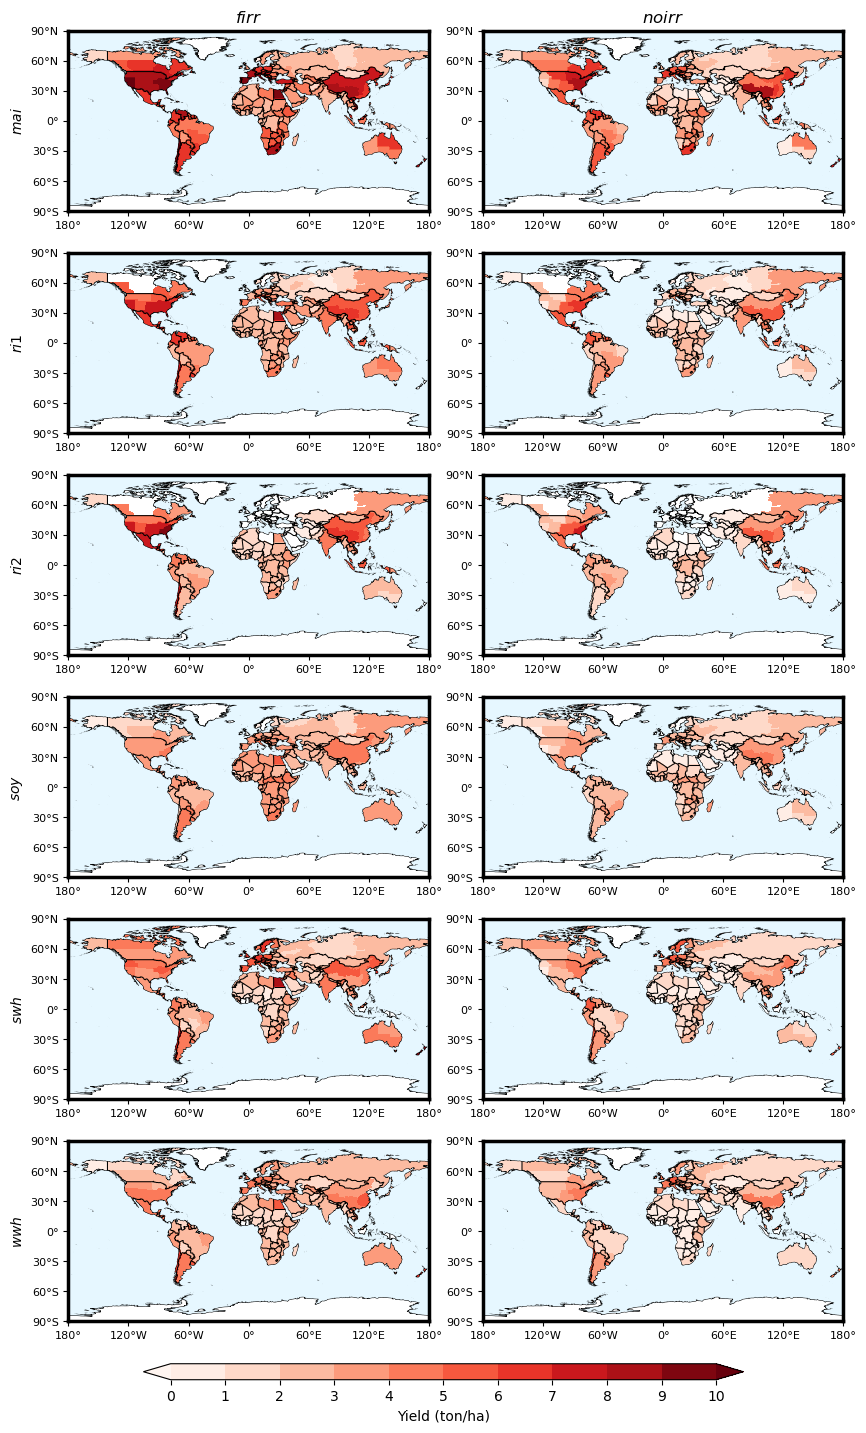

In [ ]:
## 5. plot global map
from core_fct.fct_pre_CROP import create_global_map

current_datetime = datetime.now()
print(f'\033[1;31;46mCurrent date and time: {current_datetime}\033[0m')

reg_p = {'mai': 'Maize', 'ri1': 'Rice', 'ri2': 'Rice', 'soy': 'Soybean', 'swh': 'Wheat', 'wwh': 'Wheat'}

MASK_EXTREME = False
YD = xr.load_dataarray('results/new/YD_noise.nc').mean(['config', 'gcm'])
if MASK_EXTREME: YD = YD*load_crop_mask()

fig, axes = plt.subplots(6, 2, figsize=(10, 16), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=0.0)}) # 6 rows for 6 crops, 2 columns for 2 yield types
for j, irr in enumerate(['firr', 'noirr']):
    for i, spc in enumerate(spcs):
        try:
            ax = axes[i, j]
            if i == 0: ax.set_title(rf'$\it{{{irr}}}$')
            if j == 0: ax.set_ylabel(rf'$\it{{{spc}}}$')
            # Emulated yield
            yd_out = YD.sel(spc_crop=spc, irr=irr, year=slice(1981, 2010)).mean('year')
            ax, cf = create_global_map(yd_out, 
                        levels=np.linspace(0, 10, 11), 
                        ax=ax, 
                        cb_on=False, 
                        contourf_kwargs={'cmap': 'Reds'}, 
                        colorbar_kwargs={'extend': 'max', 'extendrect': False}
                    )
            ax.tick_params(axis='both', which='major', labelsize=8)
        except KeyError:
            ax0 = axes[i, 0]
            ax.tick_params(labelbottom=False, labelleft=False)
            ax.text(
                0.5, 0.5, 
                'No Data', 
                transform=ax.transAxes,
                ha='center', 
                va='center', 
                color='gray'
            )

fig.subplots_adjust(bottom=0.08, top=0.9, hspace=0.1, wspace=0.15)
cbar_ax = fig.add_axes([0.2, 0.05, 0.6, 0.01])  # [left, bottom, width, height]
fig.colorbar(cf, cax=cbar_ax, label=rf'Yield (ton/ha)', orientation='horizontal', extend='max', ticks=np.linspace(0, 10, 11), extendrect=False)
plt.show()

<xarray.Dataset>
Dimensions:   (spc_crop: 6)
Coordinates:
  * spc_crop  (spc_crop) <U3 'mai' 'ri1' 'ri2' 'soy' 'swh' 'wwh'
Data variables:
    SC        (spc_crop) float64 0.0013 0.0006351 ... 0.001215 0.001215
    ST        (spc_crop) float64 -0.03735 -0.05683 -0.05683 ... -0.1174 -0.1174


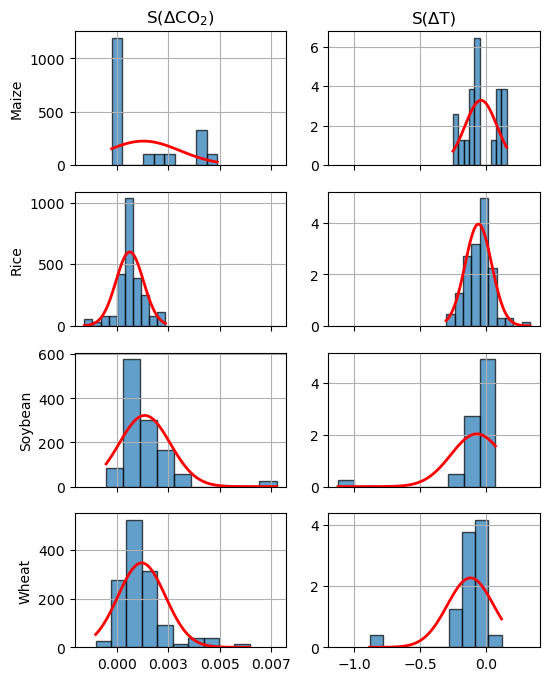

In [5]:
## 6. deal with experiment data

crop_mapping = {'Maize': ['mai'], 'Rice':['ri1', 'ri2'], 'Soybean':['soy'], 'Wheat':['swh', 'wwh']}
dir = '/h/u145/liuxinrui/Data/'

sens = xr.Dataset()
sens.coords['spc_crop'] = spcs
sens['SC'] = xr.DataArray(np.nan * np.zeros(len(spcs)), dims=['spc_crop'], coords={'spc_crop': spcs})
sens['SC'].attrs['long_name'] = 'Sensitivity of yield to CO2'
sens['ST'] = xr.DataArray(np.nan * np.zeros(len(spcs)), dims=['spc_crop'], coords={'spc_crop': spcs})
sens['ST'].attrs['long_name'] = 'Sensitivity of yield to temperature'

fig, axes = plt.subplots(4, 2, figsize=(6, 8))
for s, crop in enumerate(crop_mapping.keys()):
    xlsx = os.path.join(dir, 'Experiment', f'{crop}_Yield.xlsx')
    df = pd.read_excel(xlsx, sheet_name='Database', header=0, index_col=[0])
    data_sc = df['S(ΔCO2)'].dropna()
    mu_sc, std_sc = norm.fit(data_sc)
    x_sc = np.linspace(data_sc.min(), data_sc.max(), 100)
    p_sc = norm.pdf(x_sc, mu_sc, std_sc)
    data_st = df['S(ΔT)'].dropna()
    mu_st, std_st = norm.fit(data_st)
    x_st = np.linspace(data_st.min(), data_st.max(), 100)
    p_st = norm.pdf(x_st, mu_st, std_st)

    ax_sc = axes[s, 0]
    ax_sc.hist(data_sc, bins=10, edgecolor='black', alpha=0.7, density=True)
    ax_sc.plot(x_sc, p_sc, 'r-', linewidth=2)
    ax_sc.set_ylabel(f'{crop}')
    ax_sc.xaxis.set_major_formatter(ticker.FormatStrFormatter('%.3f'))
    ax_sc.grid(True)

    ax_st = axes[s, 1]
    ax_st.hist(data_st, bins=10, edgecolor='black', alpha=0.7, density=True)
    ax_st.plot(x_st, p_st, 'r-', linewidth=2)
    ax_st.grid(True)

    if s == 0:
        ax_sc.set_title(rf'S(ΔCO$_2$)')
        ax_st.set_title(rf'S(ΔT)')
    if s < 3:
        ax_sc.set_xlabel('')
        ax_sc.tick_params(labelbottom=False)
        ax_st.set_xlabel('')
        ax_st.tick_params(labelbottom=False)
    if s > 0:
        ax_sc.sharex(axes[0, 0])
        ax_st.sharex(axes[0, 1])

    for i, spc in enumerate(crop_mapping[crop]):
        sens['SC'].loc[{'spc_crop': spc}] = data_sc.mean()
        sens['SC'].attrs['std'] = data_sc.std()
        sens['ST'].loc[{'spc_crop': spc}] = data_st.mean()
        sens['ST'].attrs['std'] = data_st.std()
print(sens)
plt.show()

mai	ΔCO2	Exp:  200	Sim: -199	2041–2060
mai	ΔT	Exp:  2.46	Sim: -2.49	2042–2061
ri1	ΔCO2	Exp:  210	Sim: -206	2042–2061
ri1	ΔT	Exp:  2.84	Sim: -2.82	2055–2074
ri2	ΔCO2	Exp:  210	Sim: -206	2042–2061
ri2	ΔT	Exp:  2.84	Sim: -2.86	2055–2074
soy	ΔCO2	Exp:  251	Sim: -254	2048–2067
soy	ΔT	Exp:  3.12	Sim: -3.13	2050–2069
swh	ΔCO2	Exp:  207	Sim: -206	2042–2061
swh	ΔT	Exp:  1.88	Sim: -1.87	2032–2051
wwh	ΔCO2	Exp:  207	Sim: -206	2042–2061
wwh	ΔT	Exp:  1.88	Sim: -1.86	2033–2052


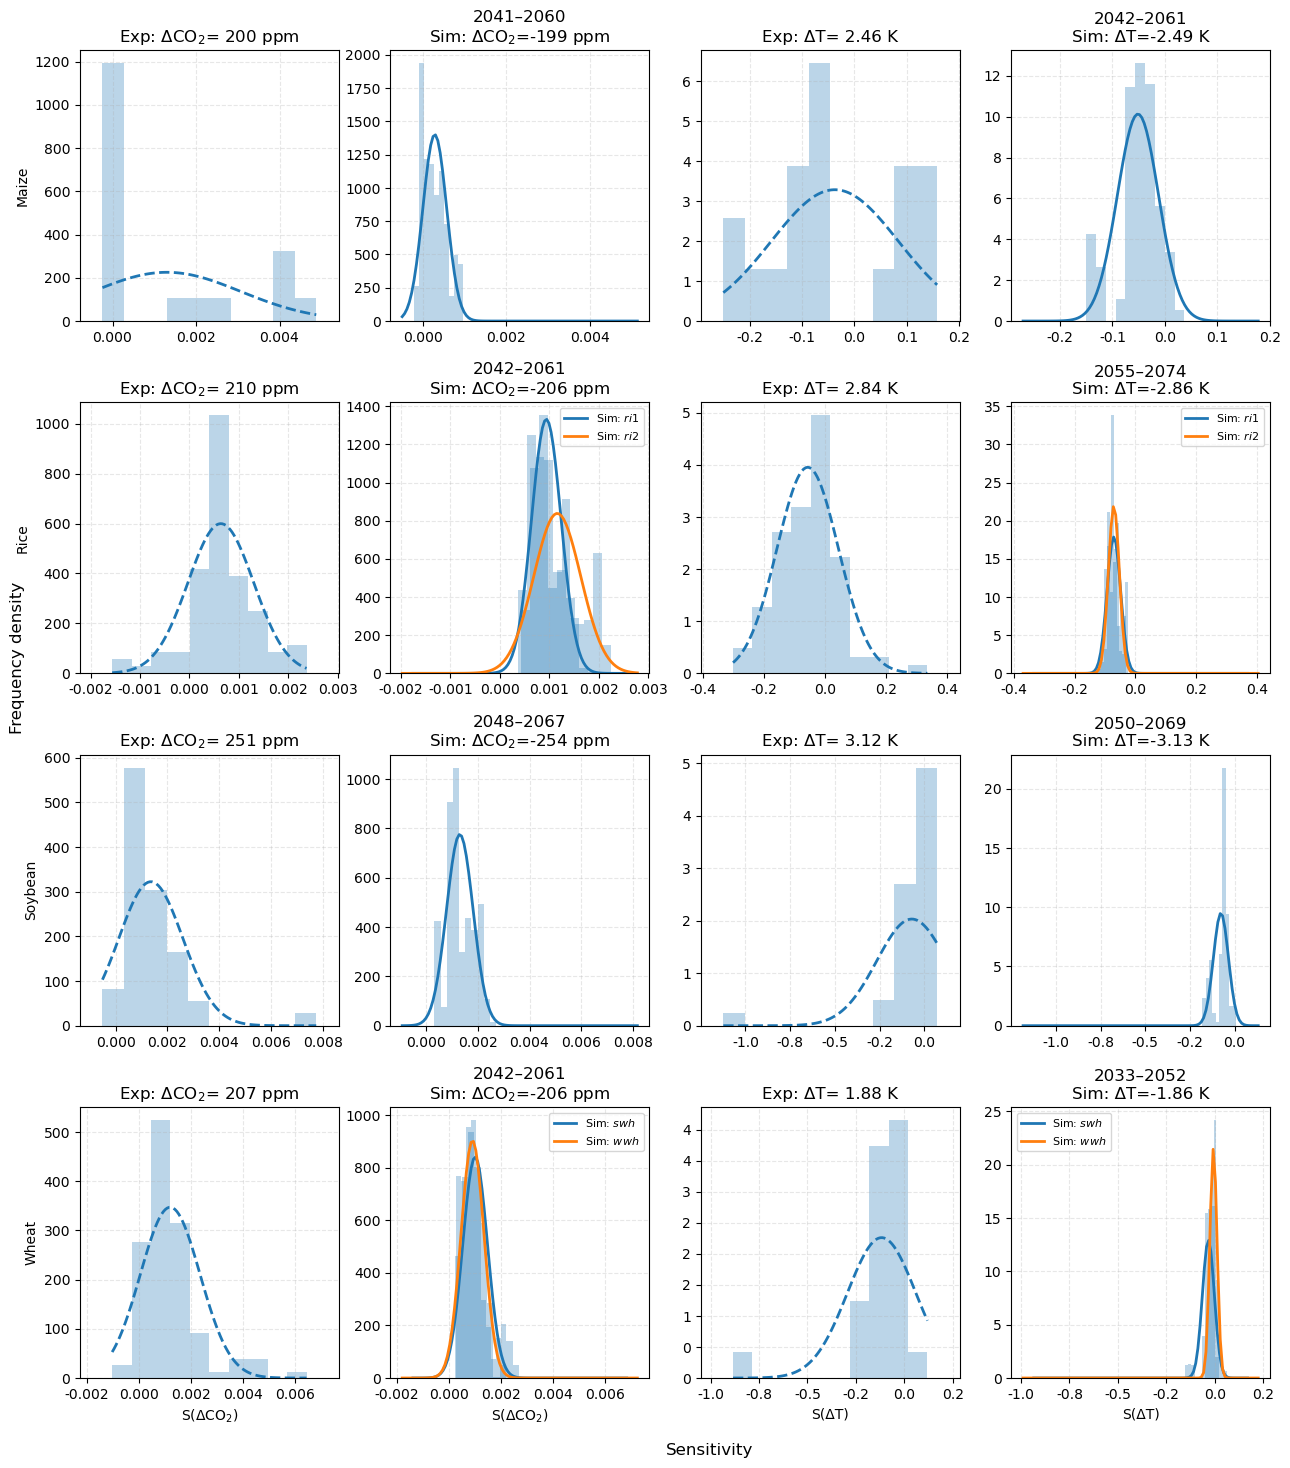

In [15]:
## 7. generate output constraints

plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.tab10.colors)
OUTPUT_CON = True

ind1 = (1991, 2010)
co2 = For_co2['CO2']
fig, axes = plt.subplots(len(crop_mapping), 2 * 2, figsize=(14, 4 * len(crop_mapping)))
weight = []
for s, crop in enumerate(crop_mapping.keys()):
    xlsx = os.path.join(dir, 'Experiment', f'{crop}_Yield.xlsx')
    df = pd.read_excel(xlsx, sheet_name='Database', header=0, index_col=[0])

    ax_sc_exp = axes[s, 0]
    ax_sc_sim = axes[s, 1]
    ax_sc_exp.sharex(ax_sc_sim)
    ax_st_exp = axes[s, 2]
    ax_st_sim = axes[s, 3]
    ax_st_exp.sharex(ax_st_sim)

    if 'S(ΔCO2)' in df.columns:
        data_sc = df[['ΔCO2', 'S(ΔCO2)']].dropna(subset=['S(ΔCO2)'])
        mu_sc, std_sc = norm.fit(data_sc['S(ΔCO2)'])
        x_sc = np.linspace(data_sc['S(ΔCO2)'].min(), data_sc['S(ΔCO2)'].max(), 100)
        p_sc = norm.pdf(x_sc, mu_sc, std_sc)
        ax_sc_exp.hist(data_sc['S(ΔCO2)'], bins=10, alpha=0.3, density=True)
        ax_sc_exp.plot(x_sc, p_sc, c='tab:blue', ls='--', linewidth=2)
        ax_sc_exp.set_title(rf'Exp: ΔCO$_2$={data_sc['ΔCO2'].mean(): .0f} ppm')
        ax_sc_exp.set_xlabel(rf'S(ΔCO$_2$)')
        ax_sc_exp.set_ylabel(f'{crop}')
        ax_sc_exp.grid(True, which='both', ls='--', alpha=0.3)
        ax_sc_exp.xaxis.set_major_formatter(ticker.FormatStrFormatter('%.3f'))
        ax_sc_exp.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.0f'))
    else:
        print(f'Warning: \'S(ΔCO2)\' column not found')
        ax_sc_exp.set_title(rf'{crop} - Exp S(ΔCO$_2$) - Not Found')

    if 'S(ΔT)' in df.columns:
        data_st = df[['ΔT', 'S(ΔT)']].dropna(subset=['S(ΔT)'])
        mu_st, std_st = norm.fit(data_st['S(ΔT)'])
        x_st = np.linspace(data_st['S(ΔT)'].min(), data_st['S(ΔT)'].max(), 100)
        p_st = norm.pdf(x_st, mu_st, std_st)
        ax_st_exp.hist(data_st['S(ΔT)'], bins=10, alpha=0.3, density=True)
        ax_st_exp.plot(x_st, p_st, c='tab:blue', ls='--', linewidth=2)
        ax_st_exp.set_title(f'Exp: ΔT={data_st['ΔT'].mean(): .2f} K')
        ax_st_exp.set_xlabel('S(ΔT)')
        ax_st_exp.grid(True, which='both', ls='--', alpha=0.3)
        ax_st_exp.xaxis.set_major_formatter(ticker.FormatStrFormatter('%.1f'))
        ax_st_exp.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.0f'))
    else:
        print(f'Warning: \'S(ΔT)\' column not found')
        ax_st_exp.set_title(f'{crop} - Exp S(ΔT) - Not Found')

    # --- Data Storage in xarray ---
    for spc in crop_mapping[crop]:
        if 'S(ΔCO2)' in df.columns:
            sens['SC'].loc[{'spc_crop': spc}] = data_sc['S(ΔCO2)'].mean()
            sens['SC'].attrs['std'] = data_sc['S(ΔCO2)'].std()
        else:
            sens['SC'].loc[{'spc_crop': spc}] = np.nan
        if 'S(ΔT)' in df.columns:
            sens['ST'].loc[{'spc_crop': spc}] = data_st['S(ΔT)'].mean()
            sens['ST'].attrs['std'] = data_st['S(ΔT)'].std()
        else:
            sens['ST'].loc[{'spc_crop': spc}] = np.nan

    for i, spc in enumerate(crop_mapping[crop]):  # Use crop_mapping[crop]
        con_avg_sc = sens['SC'].sel(spc_crop=spc)
        con_std_sc = sens['SC'].attrs['std']
        sc = YD.sel(spc_crop=spc) / RT.sel(spc_crop=spc) / RP.sel(spc_crop=spc)
        ind_opt_c = 2031
        co2_btw_opt = data_sc['ΔCO2'].mean() + (co2.sel(year=slice(*ind1)).mean('year') - co2.sel(year=slice(ind_opt_c, ind_opt_c+19)).mean('year')).values
        for ind_s in np.arange(2031, 2081):
            d_co2 = co2.sel(year=slice(*ind1)).mean('year') - co2.sel(year=slice(ind_s, ind_s+19)).mean('year')
            co2_btw = data_sc['ΔCO2'].mean() + d_co2.mean().values
            if np.abs(co2_btw) < np.abs(co2_btw_opt): ind_opt_c = ind_s; co2_btw_opt = co2_btw
        d_co2 = co2.sel(year=slice(ind_opt_c, ind_opt_c+19)).mean('year') - co2.sel(year=slice(*ind1)).mean('year')
        con_val_sc = (sc.sel(year=slice(ind_opt_c, ind_opt_c+19)).mean('year') / sc.sel(year=slice(*ind1)).mean('year') - 1) / d_co2
        wc = (1 / con_std_sc / np.sqrt(2 * np.pi) * np.exp(-0.5 * (con_val_sc - con_avg_sc) ** 2 / con_std_sc ** 2))
        wc.name = 'Wc'
        print(f'{spc}\tΔCO2\tExp: {data_sc['ΔCO2'].mean(): .0f}\tSim: {-d_co2.values: .0f}\t{ind_opt_c:d}–{ind_opt_c+19:d}')

        con_avg_st = sens['ST'].sel(spc_crop=spc)
        con_std_st = sens['ST'].attrs['std']
        st = YD.sel(spc_crop=spc) / RC.sel(spc_crop=spc) / RP.sel(spc_crop=spc)
        ind_opt_t = 2031
        tgs_btw_opt = data_st['ΔT'].mean() + (D_Tgs.sel(spc_crop=spc, year=slice(*ind1)).mean('year') - D_Tgs.sel(spc_crop=spc, year=slice(ind_opt_t, ind_opt_t+19)).mean('year')).mean().values
        for ind_s in np.arange(2031, 2081):
            d_tgs = D_Tgs.sel(spc_crop=spc, year=slice(*ind1)).mean('year') - D_Tgs.sel(spc_crop=spc, year=slice(ind_s, ind_s+19)).mean('year')
            tgs_btw = data_st['ΔT'].mean() + d_tgs.mean().values
            if np.abs(tgs_btw) < np.abs(tgs_btw_opt): ind_opt_t = ind_s; tgs_btw_opt = tgs_btw
        d_tgs = D_Tgs.sel(spc_crop=spc, year=slice(ind_opt_t, ind_opt_t+19)).mean('year') - D_Tgs.sel(spc_crop=spc, year=slice(*ind1)).mean('year')
        con_val_st = (st.sel(year=slice(ind_opt_t, ind_opt_t+19)).mean('year') / st.sel(year=slice(*ind1)).mean('year') - 1) / d_tgs
        wt = (1 / con_std_st / np.sqrt(2 * np.pi) * np.exp(-0.5 * (con_val_st - con_avg_st) ** 2 / con_std_st ** 2))
        wt.name = 'Wt'
        print(f'{spc}\tΔT\tExp: {data_st['ΔT'].mean(): .2f}\tSim: {-d_tgs.mean().values: .2f}\t{ind_opt_t:d}–{ind_opt_t+19:d}')
        
        weight.append(wc.fillna(0).assign_coords(spc_crop=spc).expand_dims('spc_crop'))
        weight.append(wt.fillna(0).assign_coords(spc_crop=spc).expand_dims('spc_crop'))

        # --- Plotting simulated data ---
        df_sc_sim = con_val_sc.to_dataframe('RC').dropna(subset=['RC'])
        mu_sc, std_sc = norm.fit(df_sc_sim['RC'])
        x_sc = np.linspace(*ax_sc_sim.get_xlim(), 100)
        p_sc = norm.pdf(x_sc, mu_sc, std_sc)
        ax_sc_sim.plot(x_sc, p_sc, linewidth=2, label=rf'Sim: $\it{{{spc}}}$')
        color = ax_sc_sim.get_lines()[0].get_color()
        ax_sc_sim.hist(df_sc_sim['RC'], bins=10, alpha=0.3, density=True, color=color)
        ax_sc_sim.set_title(f'{ind_opt_c:d}–{ind_opt_c+19:d}\n'
                            rf'Sim: ΔCO$_2$={-d_co2.mean().values: .0f} ppm')
        ax_sc_sim.set_xlabel(rf'S(ΔCO$_2$)')
        ax_sc_sim.grid(True, which='both', ls='--', alpha=0.3)
        ax_sc_sim.xaxis.set_major_formatter(ticker.FormatStrFormatter('%.3f'))

        df_st_sim = con_val_st.to_dataframe('RT').dropna(subset=['RT'])
        mu_st, std_st = norm.fit(df_st_sim['RT'])
        x_st = np.linspace(*ax_st_sim.get_xlim(), 100)
        p_st = norm.pdf(x_st, mu_st, std_st)
        ax_st_sim.plot(x_st, p_st, linewidth=2, label=rf'Sim: $\it{{{spc}}}$')
        color = ax_st_sim.get_lines()[0].get_color()
        ax_st_sim.hist(df_st_sim['RT'], bins=10, alpha=0.3, density=True, color=color)
        ax_st_sim.set_title(f'{ind_opt_t:d}–{ind_opt_t+19:d}\n'
                            f'Sim: ΔT={-d_tgs.mean().values: .2f} K')
        ax_st_sim.set_xlabel('S(ΔT)')
        ax_st_sim.grid(True, which='both', ls='--', alpha=0.3)
        ax_st_sim.xaxis.set_major_formatter(ticker.FormatStrFormatter('%.1f'))

        if crop in ['Rice', 'Wheat']:
            ax_sc_sim.legend(fontsize=8)
            ax_st_sim.legend(fontsize=8)
        if s != 0:
            ax_sc_sim.set_ylabel('')
            ax_st_exp.set_ylabel('')
            ax_st_sim.set_ylabel('')
        if s != 3:
            ax_sc_exp.set_xlabel('')
            ax_sc_sim.set_xlabel('')
            ax_st_exp.set_xlabel('')
            ax_st_sim.set_xlabel('')

fig.supxlabel('Sensitivity', y=0.0, va='bottom')
fig.supylabel('Frequency density', x=0.0, ha='left')
plt.subplots_adjust(bottom=0.05, left=0.05, hspace=0.3, wspace=0.2)
plt.show()

weight = xr.merge(weight)
if OUTPUT_CON:
    weight = weight.fillna(0)
    weight.to_netcdf('results/constraints.nc')

mai	ΔCO2	Exp:  200	Sim: -199	2041–2060
mai	S(ΔCO2)	Exp:  0.00130	Sim:  0.00028
mai	ΔT	Exp:  2.46	Sim: -2.49	2042–2061
mai	S(ΔT)	Exp: -0.04	Sim: -0.05
ri1	ΔCO2	Exp:  210	Sim: -206	2042–2061
ri1	S(ΔCO2)	Exp:  0.00064	Sim:  0.00094
ri1	ΔT	Exp:  2.84	Sim: -2.82	2055–2074
ri1	S(ΔT)	Exp: -0.06	Sim: -0.07
ri2	ΔCO2	Exp:  210	Sim: -206	2042–2061
ri2	S(ΔCO2)	Exp:  0.00064	Sim:  0.00116
ri2	ΔT	Exp:  2.84	Sim: -2.86	2055–2074
ri2	S(ΔT)	Exp: -0.06	Sim: -0.07
soy	ΔCO2	Exp:  251	Sim: -254	2048–2067
soy	S(ΔCO2)	Exp:  0.00136	Sim:  0.00131
soy	ΔT	Exp:  3.12	Sim: -3.13	2050–2069
soy	S(ΔT)	Exp: -0.07	Sim: -0.08
swh	ΔCO2	Exp:  207	Sim: -206	2042–2061
swh	S(ΔCO2)	Exp:  0.00122	Sim:  0.00100
swh	ΔT	Exp:  1.88	Sim: -1.87	2032–2051
swh	S(ΔT)	Exp: -0.12	Sim: -0.03
wwh	ΔCO2	Exp:  207	Sim: -206	2042–2061
wwh	S(ΔCO2)	Exp:  0.00122	Sim:  0.00090
wwh	ΔT	Exp:  1.88	Sim: -1.86	2033–2052
wwh	S(ΔT)	Exp: -0.12	Sim: -0.01


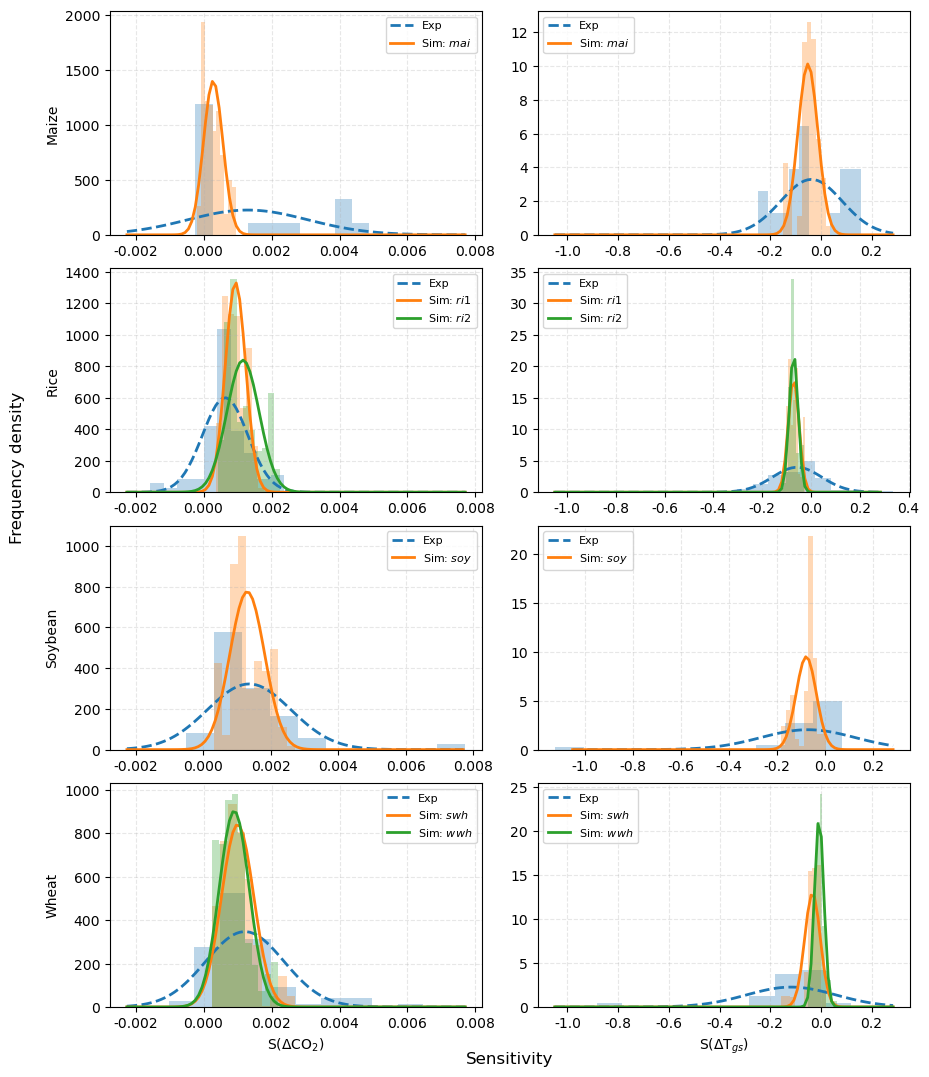

In [18]:
## 8. compare sensitivities

plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.tab10.colors)
OUTPUT_CON = True

ind1 = (1991, 2010)
co2 = For_co2['CO2']
fig, axes = plt.subplots(len(crop_mapping), 2 , figsize=(10, 3 * len(crop_mapping)))
weight = []
for s, crop in enumerate(crop_mapping.keys()):
    xlsx = os.path.join(dir, 'Experiment', f'{crop}_Yield.xlsx')
    df = pd.read_excel(xlsx, sheet_name='Database', header=0, index_col=[0])

    ax_sc = axes[s, 0]
    ax_st = axes[s, 1]

    if 'S(ΔCO2)' in df.columns:
        data_sc = df[['ΔCO2', 'S(ΔCO2)']].dropna(subset=['S(ΔCO2)'])
        mu_sc, std_sc = norm.fit(data_sc['S(ΔCO2)'])
        x_sc = np.linspace(*ax_sc_sim.get_xlim(), 100)
        p_sc = norm.pdf(x_sc, mu_sc, std_sc)
        ax_sc.hist(data_sc['S(ΔCO2)'], bins=10, alpha=0.3, density=True)
        ax_sc.plot(x_sc, p_sc, 'tab:blue', ls='--', linewidth=2, label='Exp')
        ax_sc.set_xlabel(rf'S(ΔCO$_2$)')
        ax_sc.set_ylabel(f'{crop}')
        ax_sc.grid(True, which='both', ls='--', alpha=0.3)
        ax_sc.xaxis.set_major_formatter(ticker.FormatStrFormatter('%.3f'))
        ax_sc.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.0f'))
    else:
        print(f'Warning: \'S(ΔCO2)\' column not found')
        ax_sc_exp.set_title(rf'{crop} - Exp S(ΔCO$_2$) - Not Found')

    if 'S(ΔT)' in df.columns:
        data_st = df[['ΔT', 'S(ΔT)']].dropna(subset=['S(ΔT)'])
        mu_st, std_st = norm.fit(data_st['S(ΔT)'])
        x_st = np.linspace(*ax_st_sim.get_xlim(), 100)
        p_st = norm.pdf(x_st, mu_st, std_st)
        ax_st.hist(data_st['S(ΔT)'], bins=10, alpha=0.3, density=True)
        ax_st.plot(x_st, p_st, 'tab:blue', ls='--', linewidth=2, label='Exp')
        ax_st.set_xlabel('S(ΔT$_{gs}$)')
        ax_st.grid(True, which='both', ls='--', alpha=0.3)
        ax_st.xaxis.set_major_formatter(ticker.FormatStrFormatter('%.1f'))
        ax_st.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.0f'))
    else:
        print(f'Warning: \'S(ΔT)\' column not found')
        ax_st.set_title(f'{crop} - Exp S(ΔT) - Not Found')

    # --- Data Storage in xarray ---
    for spc in crop_mapping[crop]:
        if 'S(ΔCO2)' in df.columns:
            sens['SC'].loc[{'spc_crop': spc}] = data_sc['S(ΔCO2)'].mean()
            sens['SC'].attrs['std'] = data_sc['S(ΔCO2)'].std()
        else:
            sens['SC'].loc[{'spc_crop': spc}] = np.nan
        if 'S(ΔT)' in df.columns:
            sens['ST'].loc[{'spc_crop': spc}] = data_st['S(ΔT)'].mean()
            sens['ST'].attrs['std'] = data_st['S(ΔT)'].std()
        else:
            sens['ST'].loc[{'spc_crop': spc}] = np.nan

    for i, spc in enumerate(crop_mapping[crop]):  # Use crop_mapping[crop]
        con_avg_sc = sens['SC'].sel(spc_crop=spc)
        con_std_sc = sens['SC'].attrs['std']
        sc = YD.sel(spc_crop=spc) / RT.sel(spc_crop=spc) / RP.sel(spc_crop=spc)
        ind_opt_c = 2031
        co2_btw_opt = data_sc['ΔCO2'].mean() + (co2.sel(year=slice(*ind1)).mean('year') - co2.sel(year=slice(ind_opt_c, ind_opt_c+19)).mean('year')).values
        for ind_s in np.arange(2031, 2081):
            d_co2 = co2.sel(year=slice(*ind1)).mean('year') - co2.sel(year=slice(ind_s, ind_s+19)).mean('year')
            co2_btw = data_sc['ΔCO2'].mean() + d_co2.mean().values
            if np.abs(co2_btw) < np.abs(co2_btw_opt): ind_opt_c = ind_s; co2_btw_opt = co2_btw
        d_co2 = co2.sel(year=slice(ind_opt_c, ind_opt_c+19)).mean('year') - co2.sel(year=slice(*ind1)).mean('year')
        con_val_sc = (sc.sel(year=slice(ind_opt_c, ind_opt_c+19)).mean('year') / sc.sel(year=slice(*ind1)).mean('year') - 1) / d_co2

        con_avg_st = sens['ST'].sel(spc_crop=spc)
        con_std_st = sens['ST'].attrs['std']
        st = YD.sel(spc_crop=spc) / RC.sel(spc_crop=spc) / RP.sel(spc_crop=spc)
        ind_opt_t = 2031
        tgs_btw_opt = data_st['ΔT'].mean() + (D_Tgs.sel(spc_crop=spc, year=slice(*ind1)).mean('year') - D_Tgs.sel(spc_crop=spc, year=slice(ind_opt_t, ind_opt_t+19)).mean('year')).mean().values
        for ind_s in np.arange(2031, 2081):
            d_tgs = D_Tgs.sel(spc_crop=spc, year=slice(*ind1)).mean('year') - D_Tgs.sel(spc_crop=spc, year=slice(ind_s, ind_s+19)).mean('year')
            tgs_btw = data_st['ΔT'].mean() + d_tgs.mean().values
            if np.abs(tgs_btw) < np.abs(tgs_btw_opt): ind_opt_t = ind_s; tgs_btw_opt = tgs_btw
        d_tgs = D_Tgs.sel(spc_crop=spc, year=slice(ind_opt_t, ind_opt_t+19)).mean('year') - D_Tgs.sel(spc_crop=spc, year=slice(*ind1)).mean('year')
        con_val_st = (st.sel(year=slice(ind_opt_t, ind_opt_t+19)).mean('year') / st.sel(year=slice(*ind1)).mean('year') - 1) / d_tgs
        
        # --- Plotting simulated data ---
        df_sc_sim = con_val_sc.to_dataframe('RC').dropna(subset=['RC'])
        mu_sc, std_sc = norm.fit(df_sc_sim['RC'])
        x_sc = np.linspace(*ax_sc_sim.get_xlim(), 100)
        p_sc = norm.pdf(x_sc, mu_sc, std_sc)
        ax_sc.plot(x_sc, p_sc, linewidth=2, label=rf'Sim: $\it{{{spc}}}$')
        color = ax_sc.get_lines()[-1].get_color()
        ax_sc.hist(df_sc_sim['RC'], bins=10, alpha=0.3, density=True, color=color)

        df_st_sim = con_val_st.to_dataframe('RT').dropna(subset=['RT'])
        mu_st, std_st = norm.fit(df_st_sim['RT'])
        x_st = np.linspace(*ax_st_sim.get_xlim(), 100)
        p_st = norm.pdf(x_st, mu_st, std_st)
        ax_st.plot(x_st, p_st, linewidth=2, label=rf'Sim: $\it{{{spc}}}$')
        color = ax_st.get_lines()[-1].get_color()
        ax_st.hist(df_st_sim['RT'], bins=10, alpha=0.3, density=True, color=color)

        print(f'{spc}\tΔCO2\tExp: {data_sc['ΔCO2'].mean(): .0f}\tSim: {-d_co2.values: .0f}\t{ind_opt_c:d}–{ind_opt_c+19:d}')
        print(f'{spc}\tS(ΔCO2)\tExp: {data_sc['S(ΔCO2)'].mean(): .5f}\tSim: {df_sc_sim['RC'].mean(): .5f}')
        print(f'{spc}\tΔT\tExp: {data_st['ΔT'].mean(): .2f}\tSim: {-d_tgs.mean().values: .2f}\t{ind_opt_t:d}–{ind_opt_t+19:d}')
        print(f'{spc}\tS(ΔT)\tExp: {data_st['S(ΔT)'].mean(): .2f}\tSim: {df_st_sim['RT'].mean(): .2f}')

        ax_sc.legend(fontsize=8, loc='upper right')
        ax_st.legend(fontsize=8, loc='upper left')
        if s != 3:
            ax_sc.set_xlabel('')
            ax_st.set_xlabel('')

plt.subplots_adjust(bottom=0.05, left=0.1, hspace=0.15, wspace=0.15)
fig.supxlabel('Sensitivity', y=0.0, va='bottom')
fig.supylabel('Frequency density', x=0.0, ha='left')
plt.show()

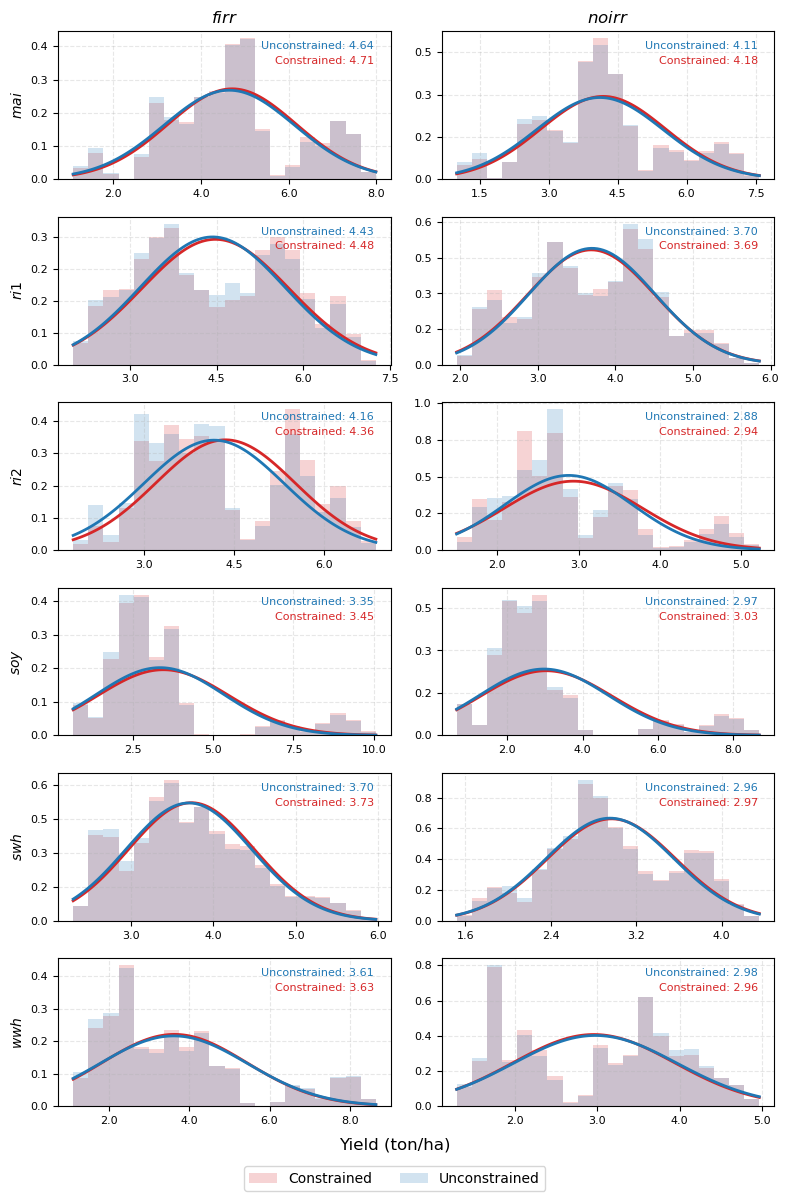

In [16]:
## 9. plot the distribution

fig, axes = plt.subplots(6, 2, figsize=(8, 12))

PLOT_TYPE = 'hist'
yd = YD.sel(year=slice(2069, 2099)).mean('year').rename({'gcm': 'mod_clim_gcm'})
weight = xr.load_dataset('results/constraints.nc')
legend_handles = []
for s, spc in enumerate(spcs):
    for j, irr in enumerate(['firr', 'noirr']):
        ax = axes[s, j]
        ax.grid(True, which='both', ls='--', alpha=0.3)
        ax.tick_params(axis='both', which='major', labelsize=8)
        ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: '{:.1f}'.format(x)))
        ax.xaxis.set_major_locator(ticker.MaxNLocator(5))
        ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: '{:.1f}'.format(x)))
        ax.yaxis.set_major_locator(ticker.MaxNLocator(5))
        
        yd_spc = yd.sel(spc_crop=spc, irr=irr).rename('Yield')
        w = ((weight['Wc'].sel(spc_crop=spc, irr=irr))*(weight['Wt'].sel(spc_crop=spc, irr=irr))).rename('Weight')
        yd_spc_con = yd_spc.weighted(w).mean()
        yd_spc_un = yd_spc.mean()
        df = xr.merge([yd_spc, w]).to_dataframe().dropna(subset=['Yield', 'Weight'])

        if PLOT_TYPE == 'kde':
            sns.kdeplot(
                data=df,
                x='Yield',
                weights='Weight',
                ax=ax,
                color='tab:red',
                label='Yield',
                fill=True,
                alpha=0.2
                )
            
            sns.kdeplot(
                data=df,
                x='Yield',
                ax=ax,
                color='tab:blue',
                label='Yield',
                fill=False,
                alpha=0.5
                )

        if PLOT_TYPE == 'hist':
            n, bins, patches = ax.hist(
                x='Yield',
                data=df,
                bins=20,
                weights=df['Weight'].values,
                density=True,
                alpha=0.2,
                color='tab:red',
                fill=True,
                lw=2,
                label='Constrained'
            )
            mu_w = np.average(df['Yield'], weights=df['Weight'])
            std_w = np.sqrt(np.average((df['Yield'] - mu_w)**2, weights=df['Weight']))
            x = np.linspace(bins.min(), bins.max(), 100)
            p = norm.pdf(x, mu_w, std_w)
            ax.plot(x, p, 'tab:red', linewidth=2)

            n, bins, patches = ax.hist(
                x='Yield',
                data=df,
                bins=20,
                density=True,
                alpha=0.2,
                color='tab:blue',
                lw=2,
                label='Unconstrained'
            )
            mu_u, std_u = norm.fit(df['Yield'])
            x = np.linspace(bins.min(), bins.max(), 100)
            p = norm.pdf(x, mu_u, std_u)
            ax.plot(x, p, 'tab:blue', linewidth=2)

        ax.text(
            0.95, 0.8, 
            f'Constrained: {yd_spc_con:.2f}', 
            transform=ax.transAxes,
            ha='right', 
            va='center', 
            color='tab:red',
            fontsize=8
        )

        ax.text(
            0.95, 0.9, 
            f'Unconstrained: {yd_spc_un:.2f}', 
            transform=ax.transAxes,
            ha='right', 
            va='center', 
            color='tab:blue',
            fontsize=8
        )
        
        if s == 0: ax.set_title(rf'$\it{{{irr}}}$')
        ax.set_xlabel('')
        if j == 0: 
            ax.set_ylabel(rf'$\it{{{spc}}}$')
        else:
            ax.set_ylabel('')
        
        if s == 0 and j == 0:
            handles, labels = ax.get_legend_handles_labels()
            legend_handles.extend(handles)
        
fig.supxlabel(r'Yield (ton/ha)', y=0.035)
fig.legend(legend_handles, ['Constrained', 'Unconstrained'], loc='lower center', ncol=4)
plt.tight_layout(rect=[0, 0.02, 1, 1])
plt.show()